# PBH neutrino fluxes

Plot the neutrino flux for different PBH masses and abundances

In [1]:
from Source.flux_stuff import *

# Routine to plot fluxes for several masses and relevant backgrounds
def plot_fluxes(Mpbhs, fpbh, is_DM):
    
    if is_DM:
        sufix = "DM"
    else:
        sufix = "evaporated"
    
    # Create legend
    customlegend = []
    
    #------------
    # PBH fluxes
    #------------

    # Compute fluxes for an array of PBH masses (comment if already computed) 
    compute_flux(Mpbhs, is_DM)
    
    # Plot PBH fluxes
    for mm, Mpbh in enumerate(Mpbhs):
        
        fileflux = "fluxes/{:.1e}/flux_isDM_{}.txt".format(Mpbh, is_DM)
        E_nu, flux = np.loadtxt(fileflux, unpack=True)
        plt.loglog( E_nu, fpbh*flux, color = cols[mm], linestyle="-" )
                
        # Plot separately galactic and extragalactic flux for PBHs as DM    
        if is_DM:
            fileflux_galac = "fluxes/{:.1e}/flux_galac.txt".format(Mpbh)
            E_nu, flux_galac = np.loadtxt(fileflux_galac, unpack=True)
            plt.loglog( E_nu, fpbh*flux_galac, linestyle=":", color = cols[mm])
            fileflux_extragalac = "fluxes/{:.1e}/flux_extragalac.txt".format(Mpbh)
            E_nu, flux_exga = np.loadtxt(fileflux_extragalac, unpack=True)
            plt.loglog( E_nu, fpbh*flux_exga, linestyle="--", color = cols[mm])
            
        customlegend.append( Line2D([0], [0], color=cols[mm], lw=4, label = r"$M_{\rm PBH}=$"+scinot(Mpbh)+" g"))
        
    # Specify in legend galactic or extragalactic if PBHs are DM
    if is_DM:

        customlegend.append( Line2D([0], [0], color="black", linestyle=":", label="Galactic"))
        customlegend.append( Line2D([0], [0], color="black", linestyle="--", label="Extragalactic"))
        customlegend.append( Line2D([0], [0], color="black", linestyle="-", label="Total"))
        
    #------------
    # Background fluxes
    #------------
            
    # Load backgrounds
    backfolder = "data/backfluxes/"

    Eatm, atm_nue = np.loadtxt(backfolder+"atmnue_noosc_fluka_flux.dat",unpack=True)
    Eatm, atm_nuebar = np.loadtxt(backfolder+"atmnuebar_noosc_fluka_flux.dat",unpack=True)
    Eatm, atm_numu = np.loadtxt(backfolder+"atmnumu_noosc_fluka_flux.dat",unpack=True)
    Eatm, atm_numubar = np.loadtxt(backfolder+"atmnumubar_noosc_fluka_flux.dat",unpack=True)
    Eatm*=1.e3 # to MeV
    atmflux = (atm_nue + atm_nuebar + atm_numu + atm_numubar)/1.e7 # GeV^-1 m^-2 s^-1 -> MeV^-1 cm^-2 s^-1
    EB8, sol_B8_1, sol_B8_2, sol_B8_3 = np.loadtxt(backfolder+"B8NeutrinoFlux.dat",unpack=True)
    sol_B8 = sol_B8_1 + sol_B8_2 + sol_B8_3
    Ehep, sol_hep = np.loadtxt(backfolder+"HEPNeutrinoFlux.dat",unpack=True)
    EO15, sol_O15 = np.loadtxt(backfolder+"O15NeutrinoFlux.dat",unpack=True)
    EN13, sol_N13 = np.loadtxt(backfolder+"N13NeutrinoFlux.dat",unpack=True)
    Epp, sol_pp = np.loadtxt(backfolder+"PPNeutrinoFlux.dat",unpack=True)

    # Interpolate backgrounds
    atmint = interp1d(Eatm, atmflux, fill_value=0., bounds_error=False)
    B8int = interp1d(EB8, sol_B8, fill_value=0., bounds_error=False)
    hepint = interp1d(Ehep, sol_hep, fill_value=0., bounds_error=False)
    O15int = interp1d(EO15, sol_O15, fill_value=0., bounds_error=False)
    N13int = interp1d(EN13, sol_N13, fill_value=0., bounds_error=False)
    ppint = interp1d(Epp, sol_pp, fill_value=0., bounds_error=False)

    Ebacks = np.logspace(np.log10(Epp[0]), np.log10(Eatm[-1]), 500)

    # Sum backgrounds and correct normalization, see table III of 1812.05550 or Table 2 of 1208.5723
    backmax = atmint(Ebacks) + B8int(Ebacks)*4.59e6 + hepint(Ebacks)*8.31e3 + O15int(Ebacks)*1.56e8 + N13int(Ebacks)*2.17e8 + ppint(Ebacks)*6.03e10

    # Plot backgrounds
    plt.fill_between( Ebacks, np.zeros_like(Ebacks), backmax, color = "b", alpha=0.3)

    # Label backgrounds
    plt.text(120., 6.e-2, "Atm.")
    plt.text(20., 2.e1, r"hep")
    plt.text(6., 5.e6, r"$^8$B")
    plt.text(1.7, 1.e7, r"$^{15}$O")   

    customlegend.append( Line2D([0], [0], color="b", lw=6, linestyle="-", alpha=0.3, label="Backgrounds"))

    # Final plot settings
    plt.xlim(1., 2.e2)
    plt.ylim( 1.e-5, 1.e8 )
    plt.tick_params(axis='both', which='both', top=True, right=True, direction="in")  
    plt.grid(which="both",linestyle=":",linewidth=1)
      
    plt.legend(handles=customlegend)#, loc="lower left")
    plt.xlabel(r'$E_\nu{\rm \,\, [MeV]}$')
    if is_DM:
        plt.title(r"$f_{\rm PBH}=$"+scinot(fpbh))
    else:
        plt.title(r"$\beta'=$"+scinot(fpbh))
    plt.ylabel(r'$d\Phi/dE_\nu \,\, [{\rm MeV}^{-1}{\rm s}^{-1}{\rm cm}^{-2}]$')
    plt.savefig("figures/fluxes_"+sufix+".png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.gcf().clear()

## Compute neutrino fluxes from PBHs as Dark Matter

Mass: 1.0e+15 g
Mass: 2.0e+15 g
Mass: 4.0e+15 g


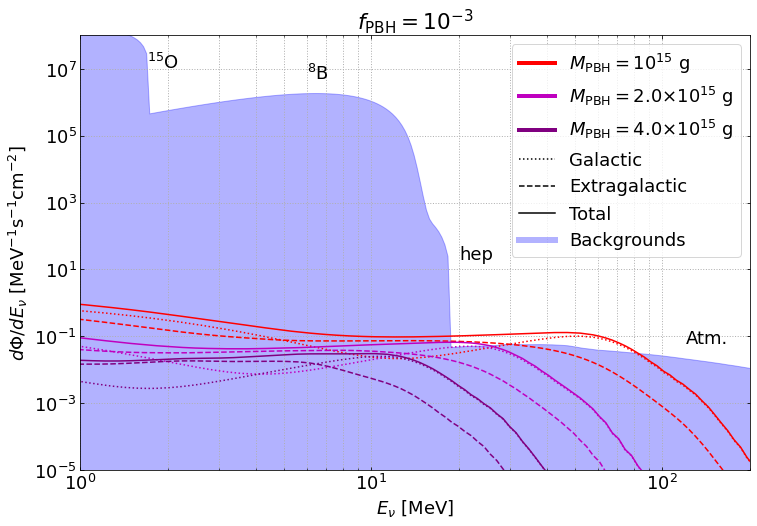

<Figure size 864x576 with 0 Axes>

In [2]:
Mpbhs =  [1e15, 2e15, 4e15]
fpbh = 1.e-3
plot_fluxes(Mpbhs, fpbh, is_DM = 1)

## Compute neutrino fluxes from evaporated PBHs

Mass: 1.0e+12 g
Mass: 1.0e+13 g
Mass: 1.0e+14 g


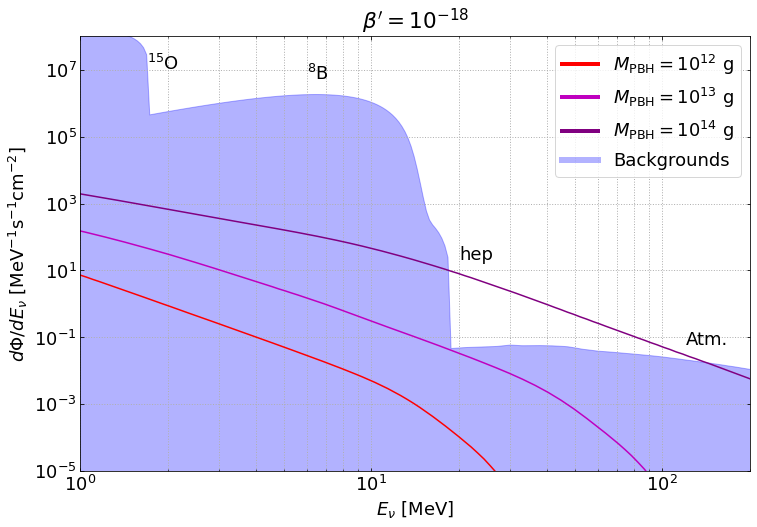

<Figure size 864x576 with 0 Axes>

In [3]:
Mpbhs = [1.e12, 1.e13, 1.e14]
fpbh = 1.e-18
plot_fluxes(Mpbhs, fpbh, is_DM = 0)